В этом ноутбуке я попытаюсь "соединить" методички ИТМО и ШАДа по логистической регрессии. Так как в ШАДе есть то, чего нет у ИТМО и наоборот. Поэтому, для полного понимания нужно читать и вникать в оба источника

https://ml-handbook.ru/chapters/linear_models/intro

https://github.com/testpassword/Machine-learning-and-data-analysis/tree/master/5%20-%20Логистическая%20регрессия

Первое, что нам понадобится это 

**Формула Бернулли.**

Пусть проводится серии из n независимых испытаний, вероятность успеха в каждом из которых равна p $\in (0,1)$. Тогда вероятность получить ровно k $\in (0,1,...,n) $ успехов равна:

$P_n(k)=\binom{n}{k} \cdot p^k ⋅ (1 - p)^{n-k}$  
Вывод:
Вероятность получить ровно $k$ успехов равна произведению вероятности события ровно $k$ раз: $p^k$. Вероятность получить n-k неудач (так как нам нужно ровно $k$ удачных исходов) это произведение вероятности неудачи ровно $n-k$ раз. По определению вероятности вероятность неудачи будет равна вероятности любого неуспешного события, стало быть: $(1-p)^{n-k}$.

Теперь учтём то что $k$ успехов могли произойти в разном порядке: к примеру если за $k$ взять 2, а за успех выпадение решки, то благоприятных исходов всего три: ОРР, РОР, РРО. Заметим что если мы выберем позицию для двух решек, то все остальные позиции будут орлами (так как успехов нам необходимо ровно два). Тогда наша задача переформулируется в: Сколько способов выбрать $k$ мест из $n$ без повторений (без повторений так как одно и то же место не может занимать сразу две буквы)? Всего разместить $k$ событий на n мест будет равно: $\frac{n!}{(n-k)!}$. А с учётом того, что там не важен позиция успеха, а важен сам факт успеха (их кол-во), делим ещё на $k!$. Конечная формула:
$\frac{n!}{k!(n-k)!}\cdot p^k \cdot (1-p)^{n-k}$



Теперь рассмотрим функцию $f(X, p) =\frac{n!}{k!(n-k)!}\cdot p^k \cdot (1-p)^{n-k}$, где X выборка из n испытаний, k - кол-во успехов, а p - вероятность упеха.
Такая функция называется функцией правдоподобия. Теперь если мы найдём такое p при котором функция максимальна, тогда мы найдём вероятность успеха, при котором этот эксперимент будет максимально возможен.
Сделать это можно обычным поиском максимума функции. Заметим также, что брать производную от этой функции трудно, так как много умножения, тогда если мы возьмём логарифм и представим по свойству логарифма это, мы получим сумму, которую очень просто дифферинцировать

Теперь подумаем вот над чем. Нам нужно предсказывать вероятность, но как обучить линейную модель предсказывать чисто от 0 до 1? Тогда воспользуемся такой идеей, будем предсказывать какое-то число, связанное с вероятностью, но от -inf до +inf и откуда можно будет выразить вероятность. Таким объектом явзяется log odds - логарифм отношения вероятности положительного исхода, к отрицательному: log(p/(1-p)).
Тогда, можем выразить вероятность принадлежности к классу: <w, xi> = log(p/(1-p))
e^<w, xi> = p/1-p
p = 1/(1 + e^-<w,xi>
функция справа зовётся сигмоидой
o(z) = 1/1+e^-z
=> p = o(<w,xi>)


Но какую функцию потерь нам выбрать? По сути мы хотим, чтобы p_i было максимально для соответствуещего класса, тогда нужно придумать функционал ошибки который позволи это сделать. Тогда поступим вот как. у нас есть sum(ln(sigma((w,x)))), домножим (w, x) на y_i - то, если класс предсказан верно то: 1. если класс 1, то (w, x) должно быть полодительно тогда, умножив на y_i (то есть на +1), ничего не изменится, а если наоборот, 



---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.datasets import make_moons

from sklearn.metrics import roc_auc_score

import matplotlib.patheffects as pe

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

<Figure size 800x600 with 0 Axes>

In [ ]:
url = 'https://raw.githubusercontent.com/tsebaka/ML-practice/main/Logistic%20regression/data.csv'
data = pd.read_csv(url)

In [ ]:
data

,x,y,class
0,-0.220234,-0.200728,-1
1,-0.040973,0.114584,-1
2,0.333306,-0.361386,1
3,-0.037119,0.253068,-1
4,0.012534,0.133582,-1
...,...,...,...
995,-0.101329,0.351058,-1
996,-0.273231,0.019574,-1
997,0.074535,0.304932,-1
998,-0.010026,-0.302007,1


In [ ]:
class_1 = data[(data == 1).any(axis=1)]
class_2 = data[(data == -1).any(axis=1)]

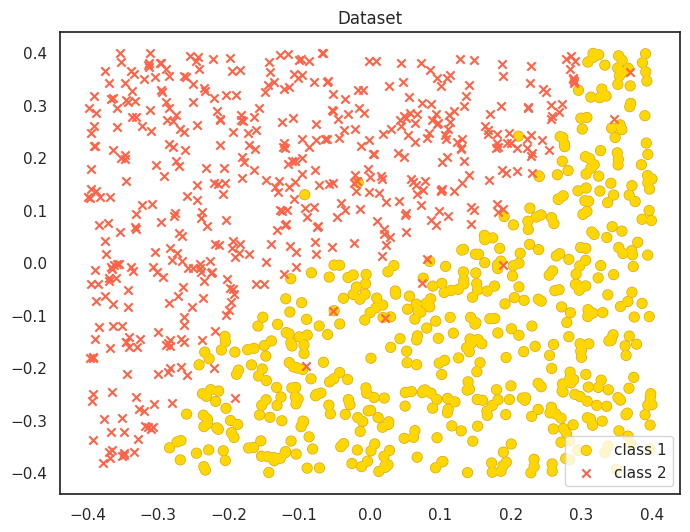

In [ ]:
plt.scatter(class_1['x'], class_1['y'], color='gold', label='class 1', path_effects=[pe.Stroke(linewidth=2, foreground='goldenrod'), pe.Normal()])
plt.scatter(class_2['x'], class_2['y'], color='tomato', label='class 2', marker="x")
plt.title('Dataset')
plt.legend()
plt.show()

In [ ]:
class LogisticRegression():
    def __init__(self, iterations=100, learning_rate=0.1, verbose=50, silence='False'):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.silence = silence

        self.init_weights()

    def init_weights(self):
        self.w = np.array([1., 1., 1.])# хз как сайз features узнать тут
    
    def computeGradient(self, X, y):
        grad = [0] * len(self.w)
        exponenta = np.exp(-y * (self.w[0] + self.w[1] * X[0] + self.w[2] * X[1]))
        grad[0] = - exponenta * y / (1 + exponenta)
        grad[1] = - exponenta * y * X[0] / (1 + exponenta)
        grad[2] = - exponenta * y * X[1] / (1 + exponenta)
        
        return grad
    
    def sigmoid(self, x):                                        
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        for i in range(self.iterations):
            for j in range(len(X)):
                grad = self.computeGradient(X[j], y[j])
                self.w[0] -= self.learning_rate * grad[0]
                self.w[1] -= self.learning_rate * grad[1]
                self.w[2] -= self.learning_rate * grad[2]

            if self.silence=='False':
                if (i + 1) % self.verbose == 0 or i == 0:
                    self.print_progress(X, y, i)

    def print_progress(self, X, y, iteration):
        y_pred = []
        for i in range(len(X)):
            y_pred.append(self.sigmoid((self.w[0] + self.w[1] * X[i][0] + self.w[2] * X[i][1])))
        print('iteration:', iteration, ' ', 'accuracy:', roc_auc_score(y, y_pred))

    def predict(self, X):
        pred = []
        for i in range(len(X)):
            pred.append(self.sigmoid((self.w[0] + self.w[1] * X[i][0] + self.w[2] * X[i][1])))
        
        return pred


In [ ]:
model = LogisticRegression(iterations=75, learning_rate=0.006, verbose=5)

In [ ]:
y = np.array(data['class'])
X = np.array(data.drop(columns='class'))

In [ ]:
model.fit(X, y)

iteration: 0   accuracy: 0.664191805727421
iteration: 4   accuracy: 0.9296466715523145
iteration: 9   accuracy: 0.9718234278826323
iteration: 14   accuracy: 0.980353288401392
iteration: 19   accuracy: 0.9826959965720373
iteration: 24   accuracy: 0.9834889131836403
iteration: 29   accuracy: 0.9836731261338106
iteration: 34   accuracy: 0.9836931492805684
iteration: 39   accuracy: 0.9837011585392714
iteration: 44   accuracy: 0.98369715390992
iteration: 49   accuracy: 0.98369715390992
iteration: 54   accuracy: 0.9837211816860291
iteration: 59   accuracy: 0.9837011585392714
iteration: 64   accuracy: 0.983713172427326
iteration: 69   accuracy: 0.9836811353925137
iteration: 74   accuracy: 0.9836651168751076


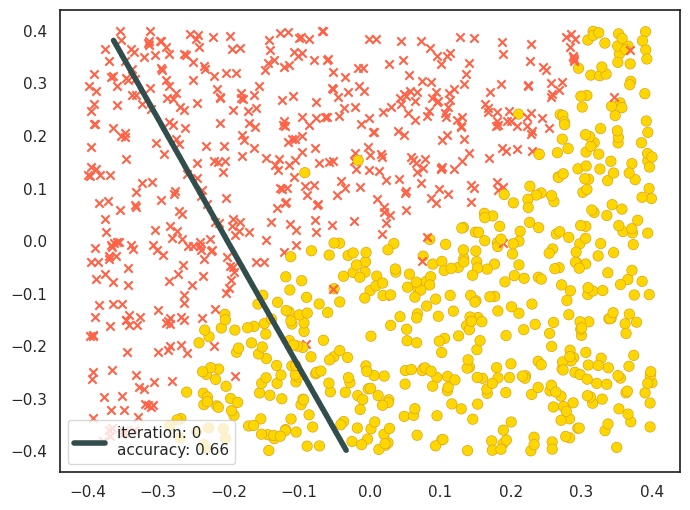

In [ ]:
class_2 = data[(data == -1).any(axis=1)]
class_2 = np.array(class_2.drop(columns='class'))
pred_2 = model.predict(class_2)

class_1 = data[(data == 1).any(axis=1)]
class_1 = np.array(class_1.drop(columns='class'))
pred_1 = model.predict(class_1)

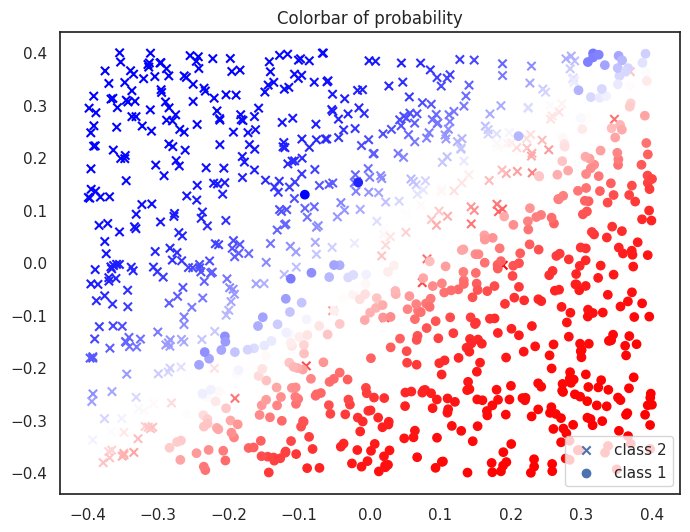

In [ ]:
plt.scatter(class_2[:, 0], class_2[:, 1], c=pred_2, label='class 2', marker="x", cmap='bwr')
plt.scatter(class_1[:, 0], class_1[:, 1], c=pred_1, label='class 1', cmap='bwr')
plt.legend()
plt.title('Colorbar of probability')
plt.show()